In [ ]:
!unzip '/content/drive/My Drive/new_data/data.zip' -d 'data'

Archive:  /content/drive/My Drive/new_data/data.zip
   creating: data/image_data/
   creating: data/image_data/paper/
  inflating: data/image_data/paper/1.jpg  
  inflating: data/image_data/paper/2.jpg  
  inflating: data/image_data/paper/3.jpg  
  inflating: data/image_data/paper/4.jpg  
  inflating: data/image_data/paper/5.jpg  
  inflating: data/image_data/paper/6.jpg  
  inflating: data/image_data/paper/7.jpg  
  inflating: data/image_data/paper/8.jpg  
  inflating: data/image_data/paper/9.jpg  
  inflating: data/image_data/paper/10.jpg  
  inflating: data/image_data/paper/11.jpg  
  inflating: data/image_data/paper/12.jpg  
  inflating: data/image_data/paper/13.jpg  
  inflating: data/image_data/paper/14.jpg  
  inflating: data/image_data/paper/15.jpg  
  inflating: data/image_data/paper/16.jpg  
  inflating: data/image_data/paper/17.jpg  
  inflating: data/image_data/paper/18.jpg  
  inflating: data/image_data/paper/19.jpg  
  inflating: data/image_data/paper/20.jpg  
  inflating

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
data_dir  = '/content/data/image_data/'
classes = os.listdir(data_dir)
print(classes)

['rock', 'scissors', 'none', 'paper']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
data_tfms = (transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))

In [ ]:
dataset = ImageFolder(data_dir, data_tfms)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 250
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(750, 250)

In [ ]:
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

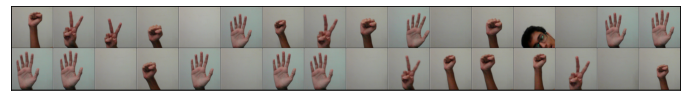

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class rpsvModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   #128

            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64

            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #32

            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #16

            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #8

            nn.Flatten(), 
            nn.Linear(128*8*8,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = rpsvModel()
model

rpsvModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=8192, out_fe

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);      #shifting data onto gpu

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(rpsvModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.23221983015537262, 'val_loss': 1.3875975608825684}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3866, val_loss: 1.3877, val_acc: 0.2322
Epoch [1], train_loss: 1.3860, val_loss: 1.3874, val_acc: 0.2322
Epoch [2], train_loss: 1.3853, val_loss: 1.3872, val_acc: 0.2322
Epoch [3], train_loss: 1.3844, val_loss: 1.3863, val_acc: 0.4050
Epoch [4], train_loss: 1.3833, val_loss: 1.3847, val_acc: 0.4011
Epoch [5], train_loss: 1.3811, val_loss: 1.3818, val_acc: 0.2901
Epoch [6], train_loss: 1.3770, val_loss: 1.3765, val_acc: 0.2980
Epoch [7], train_loss: 1.3702, val_loss: 1.3682, val_acc: 0.4293
Epoch [8], train_loss: 1.3570, val_loss: 1.3517, val_acc: 0.4054
Epoch [9], train_loss: 1.3343, val_loss: 1.3235, val_acc: 0.5524


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3090, val_loss: 1.3037, val_acc: 0.5845
Epoch [1], train_loss: 1.2856, val_loss: 1.2797, val_acc: 0.6048
Epoch [2], train_loss: 1.2558, val_loss: 1.2487, val_acc: 0.6009
Epoch [3], train_loss: 1.2188, val_loss: 1.2062, val_acc: 0.7678
Epoch [4], train_loss: 1.1693, val_loss: 1.1552, val_acc: 0.7604
Epoch [5], train_loss: 1.1063, val_loss: 1.0896, val_acc: 0.7643
Epoch [6], train_loss: 1.0335, val_loss: 1.0226, val_acc: 0.8194
Epoch [7], train_loss: 0.9581, val_loss: 0.9461, val_acc: 0.8354
Epoch [8], train_loss: 0.8762, val_loss: 0.8721, val_acc: 0.8077
Epoch [9], train_loss: 0.8005, val_loss: 0.8006, val_acc: 0.8315


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.7315, val_loss: 0.7421, val_acc: 0.8874
Epoch [1], train_loss: 0.6730, val_loss: 0.6903, val_acc: 0.8796
Epoch [2], train_loss: 0.6181, val_loss: 0.6357, val_acc: 0.8952
Epoch [3], train_loss: 0.5589, val_loss: 0.5854, val_acc: 0.9199
Epoch [4], train_loss: 0.5111, val_loss: 0.5382, val_acc: 0.9355
Epoch [5], train_loss: 0.4576, val_loss: 0.4843, val_acc: 0.9394
Epoch [6], train_loss: 0.4121, val_loss: 0.4363, val_acc: 0.9316
Epoch [7], train_loss: 0.3688, val_loss: 0.3918, val_acc: 0.9472
Epoch [8], train_loss: 0.3202, val_loss: 0.3413, val_acc: 0.9472
Epoch [9], train_loss: 0.2814, val_loss: 0.3104, val_acc: 0.9554


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.2431, val_loss: 0.2637, val_acc: 0.9554
Epoch [1], train_loss: 0.2087, val_loss: 0.2273, val_acc: 0.9632
Epoch [2], train_loss: 0.1850, val_loss: 0.1995, val_acc: 0.9710
Epoch [3], train_loss: 0.1596, val_loss: 0.1744, val_acc: 0.9754
Epoch [4], train_loss: 0.1350, val_loss: 0.1542, val_acc: 0.9836
Epoch [5], train_loss: 0.1148, val_loss: 0.1352, val_acc: 0.9836
Epoch [6], train_loss: 0.1020, val_loss: 0.1100, val_acc: 0.9836
Epoch [7], train_loss: 0.0890, val_loss: 0.0926, val_acc: 0.9918
Epoch [8], train_loss: 0.0799, val_loss: 0.0834, val_acc: 0.9961
Epoch [9], train_loss: 0.0628, val_loss: 0.0698, val_acc: 0.9961


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0574, val_loss: 0.0586, val_acc: 0.9961
Epoch [1], train_loss: 0.0453, val_loss: 0.0476, val_acc: 1.0000
Epoch [2], train_loss: 0.0375, val_loss: 0.0393, val_acc: 1.0000
Epoch [3], train_loss: 0.0320, val_loss: 0.0330, val_acc: 1.0000
Epoch [4], train_loss: 0.0275, val_loss: 0.0293, val_acc: 1.0000
Epoch [5], train_loss: 0.0232, val_loss: 0.0227, val_acc: 1.0000
Epoch [6], train_loss: 0.0184, val_loss: 0.0197, val_acc: 1.0000
Epoch [7], train_loss: 0.0159, val_loss: 0.0176, val_acc: 1.0000
Epoch [8], train_loss: 0.0131, val_loss: 0.0144, val_acc: 1.0000
Epoch [9], train_loss: 0.0116, val_loss: 0.0126, val_acc: 1.0000


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0104, val_loss: 0.0099, val_acc: 1.0000
Epoch [1], train_loss: 0.0078, val_loss: 0.0079, val_acc: 1.0000
Epoch [2], train_loss: 0.0060, val_loss: 0.0063, val_acc: 1.0000
Epoch [3], train_loss: 0.0047, val_loss: 0.0051, val_acc: 1.0000
Epoch [4], train_loss: 0.0039, val_loss: 0.0041, val_acc: 1.0000
Epoch [5], train_loss: 0.0032, val_loss: 0.0035, val_acc: 1.0000
Epoch [6], train_loss: 0.0028, val_loss: 0.0028, val_acc: 1.0000
Epoch [7], train_loss: 0.0024, val_loss: 0.0026, val_acc: 1.0000
Epoch [8], train_loss: 0.0019, val_loss: 0.0022, val_acc: 1.0000
Epoch [9], train_loss: 0.0016, val_loss: 0.0019, val_acc: 1.0000


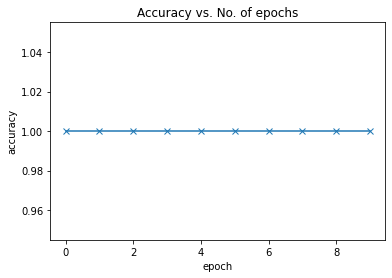

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

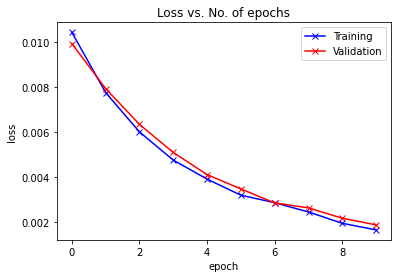

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
torch.save(model, '/content/drive/My Drive/new_data/new_weights.pth')

In [ ]:
model = torch.load('/content/drive/My Drive/new_data/new_weights.pth')
model.eval()

rpsvModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=8192, out_fe

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/new_data/new_weights_dict.pth')